all carriers:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilot carriers: [ 0  8 16 24 32 40 48 56 63]
data carriers: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


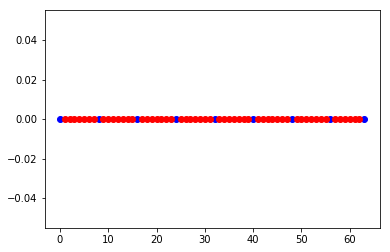

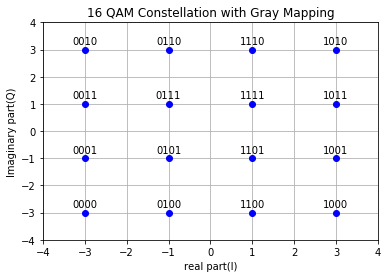

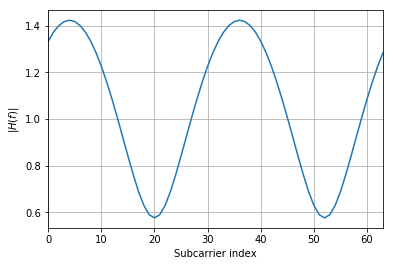

Bits count:  220
First 20 bits: [1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1]
mean of bits(should be around 0.5):  0.5227272727272727
first 5 bit groups
[[1 1 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [1 1 0 1]
 [1 0 1 1]]
fitst 5 QAM symbols and bits 
[[1 1 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [1 1 0 1]
 [1 0 1 1]]
[ 1.-3.j  1.+1.j -3.-3.j  1.-1.j  3.+1.j]
number of OFDM carriers in frequency domain: 64
number of OFDM samples in time domain before CP 64
number of OFDM samples in time domain with CP 80
some symbol (0.09630281656913896+0.1949428469090026j)
RX signal power: 0.1696. noise power :0.0005


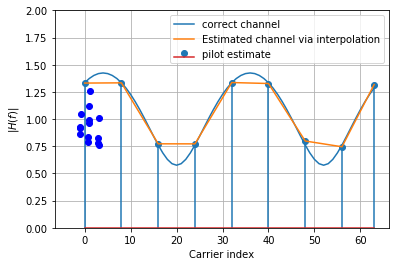

Obtained bit error rate: 0.0
RX signal power: 0.1696. noise power :0.0005


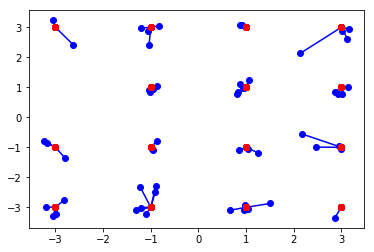

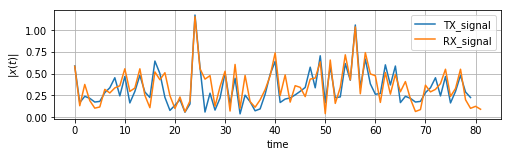

In [3]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
#%matplotlib inline

K=64 #number of ofdm subcarriers
CP=K//4 # length of cyclic prefix 25% of the block
P=8 #number of pilot carriers per ofdm block
pilotValue=3+3j  # the known value each pilot transmits

allCarriers=np.arange(K)  #indices of all subcarriers([0,1,...K-1])
pilotCarriers=allCarriers[::K//P]
pilotCarriers=np.hstack([pilotCarriers,np.array([allCarriers[-1]])])

P=P+1
#data carriers are all remaining carriers
dataCarriers=np.delete(allCarriers,pilotCarriers)

print("all carriers:  %s"  %allCarriers);
print("pilot carriers: %s" %pilotCarriers);
print("data carriers: %s"  %dataCarriers);

plt.plot(pilotCarriers,np.zeros_like(pilotCarriers),'bo',label='pilot')
plt.plot(dataCarriers,np.zeros_like(dataCarriers),'ro',label='data')
plt.show()

mu=4 # bits per symbol (i.e. 16 QAM)
payloadBits_per_OFDM=len(dataCarriers)*mu   # number of payload bits per ofdm symbol
mapping_table={
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0): -3+3j,
    (0,0,1,1):-3+1j,
    (0,1,0,0):-1-3j,
    (0,1,0,1):-1-1j,
    (0,1,1,0):-1+3j,
    (0,1,1,1):-1+1j,
    (1,0,0,0):3-3j,
    (1,0,0,1):3-1j,
    (1,0,1,0):3+3j,
    (1,0,1,1):3+1j,
    (1,1,0,0):1-3j,
    (1,1,0,1):1-1j,
    (1,1,1,0):1+3j,
    (1,1,1,1):1+1j
}

for b3 in [0,1]:
    for b2 in [0,1]:
        for b1 in [0,1]:
            for b0 in [0,1]:
                B=(b3,b2,b1,b0)
                Q=mapping_table[B]
                plt.plot(Q.real,Q.imag,'bo')
                plt.text(Q.real,Q.imag+0.2,"".join(str(x) for x in B),ha='center')
                
plt.grid(True);
plt.xlim((-4,4));plt.ylim((-4,4));plt.xlabel('real part(I)');plt.ylabel('Imaginary part(Q)');
plt.title('16 QAM Constellation with Gray Mapping');
plt.show();               
demapping_table={v:k for k,v in mapping_table.items()}


channelResponse=np.array([1,0,0.3+0.3j]) #the impluse response of the wireless channel
H_exact=np.fft.fft(channelResponse,K)
plt.plot(allCarriers,abs(H_exact));
plt.xlabel('Subcarrier index');plt.ylabel('$|H(f)|$');plt.grid(True);plt.xlim(0,K-1);
plt.show();
SNRdb=25


bits=np.random.binomial(n=1,p=0.5,size=(payloadBits_per_OFDM, ))
print("Bits count: ",len(bits))
print("First 20 bits:",bits[:20])
print("mean of bits(should be around 0.5): ",np.mean(bits))

def SP(bits):
    return bits.reshape((len(dataCarriers),mu))
bits_SP=SP(bits)
print("first 5 bit groups")
print(bits_SP[:5,:])

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM=Mapping(bits_SP)
print("fitst 5 QAM symbols and bits ")
print(bits_SP[:5,:])
print(QAM[:5])


def OFDM_symbol(QAM_payload):
    symbol=np.zeros(K,dtype=complex) #the overall K subcarriers
    symbol[pilotCarriers]=pilotValue
    symbol[dataCarriers]=QAM_payload
    return symbol
OFDM_data=OFDM_symbol(QAM)
print("number of OFDM carriers in frequency domain:",len(OFDM_data))
    
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time=IDFT(OFDM_data)
print("number of OFDM samples in time domain before CP",len(OFDM_time))

def addCP(OFDM_time):
    cp=OFDM_time[-CP:]
    return np.hstack([cp,OFDM_time])
OFDM_withCP=addCP(OFDM_time)
print("number of OFDM samples in time domain with CP",len(OFDM_withCP))
print("some symbol",OFDM_withCP[3])


def  channel(signal):
    convolved=np.convolve(signal,channelResponse)
    signal_power=np.mean(abs(convolved**2))
    sigma2=signal_power*10**(-SNRdb/10)
    print("RX signal power: %.4f. noise power :%.4f"%(signal_power,sigma2))
    
    noise=np.sqrt(sigma2/2)*(np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved+noise
OFDM_TX=OFDM_withCP
OFDM_RX=channel(OFDM_TX)

def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP=removeCP(OFDM_RX)

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod=DFT(OFDM_RX_noCP)

def channelEstimate(OFDM_demod):
    pilots=OFDM_demod[pilotCarriers]
    Hest_at_pilots=pilots/pilotValue
    
    Hest_abs=scipy.interpolate.interp1d(pilotCarriers,abs(Hest_at_pilots),kind='linear')(allCarriers)
    Hest_phase=scipy.interpolate.interp1d(pilotCarriers,np.angle(Hest_at_pilots),kind='linear')(allCarriers)
    Hest=Hest_abs*np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers,abs(H_exact),label='correct channel')
    plt.stem(pilotCarriers,abs(Hest_at_pilots),label='pilot estimate')
    plt.plot(allCarriers,abs(Hest),label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index');plt.ylabel('$|H(f)|$');plt.legend(fontsize=10)
    plt.ylim(0,2)
    return Hest
plt.show();    
Hest=channelEstimate(OFDM_demod)

def equalize(OFDM_demod,Hest):
    return OFDM_demod/Hest

equalized_Hest=equalize(OFDM_demod,Hest)

def get_payload(equalized):
    return equalized[dataCarriers]

QAM_est=get_payload(equalized_Hest)

plt.plot(QAM_est.real,QAM_est.imag,'bo')
plt.show();
def Demapping(QAM):
    constellation=np.array([x for x in demapping_table.keys()])
    dists=abs(QAM.reshape((-1,1))-constellation.reshape((1,-1)))
    const_index=dists.argmin(axis=1)
    hardDecision=constellation[const_index]
    return np.vstack([demapping_table[C] for C in hardDecision]),hardDecision
PS_est,hardDecision=Demapping(QAM_est)
for qam,hard in zip(QAM_est,hardDecision):
    plt.plot([qam.real,hard.real],[qam.imag,hard.imag],'b-o')
    plt.plot(hardDecision.real,hardDecision.imag,'ro')
    
def PS(bits):
    return bits.reshape((-1,))
bits_est=PS(PS_est)

print("Obtained bit error rate:",np.sum(abs(bits-bits_est))/len(bits))

#OFDM_withCP
OFDM_TX=OFDM_withCP
OFDM_RX=channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX),label='TX_signal')
plt.plot(abs(OFDM_RX),label='RX_signal')
plt.legend(fontsize=10)
plt.xlabel('time');plt.ylabel('$|x(t)|$');
plt.grid(True)
plt.show();


In [ ]:
help()


Welcome to Python 3.6's help utility!

If this is your first time using Python, you should definitely check out
the tutorial on the Internet at http://docs.python.org/3.6/tutorial/.

Enter the name of any module, keyword, or topic to get help on writing
Python programs and using Python modules.  To quit this help utility and
return to the interpreter, just type "quit".

To get a list of available modules, keywords, symbols, or topics, type
"modules", "keywords", "symbols", or "topics".  Each module also comes
with a one-line summary of what it does; to list the modules whose name
or summary contain a given string such as "spam", type "modules spam".

